In [323]:
import lab as B
import neuralprocesses.torch as nps
import torch
import matplotlib.pyplot as plt
from wbml.plot import tweak
import wbml.util
from wbml.data.predprey import load 
import numpy as np

from neuralprocesses.data import DataGenerator, SyntheticGenerator
from neuralprocesses.data.batch import batch_index
from neuralprocesses.dist.uniform import UniformDiscrete, UniformContinuous



%matplotlib inline
import pandas as pd

In [324]:
def _predprey_step(state, x_y, t, dt, *, alpha, beta, delta, gamma, sigma):
    x = x_y[..., 0]
    y = x_y[..., 1]

    m = 2500

    state, randn = B.randn(state, B.dtype(x), 2, *B.shape(x))
    dw = B.sqrt(dt) * randn

    deriv_x = x * (alpha - beta * y) * (1 - x / m)
    deriv_y = y * (-delta + gamma * x) * (1 - y / m)
    # Apply an exponent 0.2 to emphasise the noise at lower population levels and
    # prevent the populations from dying out.
    x = x + deriv_x * dt + 0*(x**0.2) * (1 - x / m) * sigma * dw[0]
    y = y + deriv_y * dt - 0*(y**0.2) * (1 - y / m) * sigma * dw[1]

    # Make sure that the populations never become negative. Mathematically, the
    # populations should remain positive. Note that if we were to `max(x, 0)`, then
    # `x` could become zero. We therefore take the absolute value.
    x = B.abs(x)
    y = B.abs(y)

    # Cap the populations by `m`. Mathematically, they should never rise above `m`, but
    # numerically they can due to the non-zero step size.
    x = B.minimum(x, m * B.one(x))
    y = B.minimum(y, m * B.one(y))

    t = t + dt

    return state, B.stack(x, y, axis=-1), t

In [338]:
def _predprey_simulate(state, dtype, t0, t1, dt, t_target, *, batch_size=16):
    state, params = _predprey_rand_params(state, dtype, batch_size=batch_size)

    # Sort the target times for the validity of the loop below.
    perm = B.argsort(t_target)
    inv_perm = wbml.util.inv_perm(perm)
    t_target = B.take(t_target, perm)

    # Note the magic constant 10 here.
#     x_y = 10 * B.rand(dtype, batch_size, 2)
#     x_y = B.ones(dtype, batch_size, 2) * torch.tensor([34.91, 3.857], dtype=torch.float64)
    x_y = B.ones(dtype, batch_size, 2) * torch.tensor([20., 30.], dtype=torch.float64)

    
    
    t, traj = t0, [x_y]

    while t < t1:
        state, x_y, t = _predprey_step(state, x_y, t, dt, **params)
        while B.shape(t_target, 0) > 0 and t >= t_target[0]:
            traj.append(x_y)
            t_target = t_target[1:]

    # Note the magic scaling `7 / 100` here.
    traj = B.stack(*traj, axis=-1) 

    # Undo the sorting.
    traj = B.take(traj, inv_perm, axis=-1)

    return state, traj

In [345]:

def _predprey_rand_params(state, dtype, batch_size=16):
    state, rand = B.rand(state, dtype, 5, batch_size)

#     alpha = 0.5 + rand[0]
#     beta = alpha * (0.1 + 0.2 * rand[1])
#     delta = 0.5 + rand[2]
#     gamma = delta * (0.1 + 0.2 * rand[3])

    alpha = 0.4807 
    beta  = 0.02482
    delta = 0.9272
    gamma = 0.02756


#     alpha = 0.3807 + 0.1 * (1. + rand[0])
#     beta  = 0.01482 + 0.01 * (1. + rand[0])
#     delta = 0.8272 + 0.1 * (1. + rand[0])
#     gamma = 0.01756 + 0.01 * (1. + rand[0])

    sigma = 2. * (1. + rand[4])

    return state, {
        "alpha": alpha,
        "beta": beta,
        "delta": delta,
        "gamma": gamma,
        "sigma": sigma,
    }



In [346]:

class PredPreyGenerator(SyntheticGenerator):
    """Predator–prey generator.

    Further takes in arguments and keyword arguments from the constructor of
    :class:`.data.SyntheticGenerator`. Moreover, also has the attributes of
    :class:`.data.SyntheticGenerator`. However, the defaults for this class are
    different.
    """

    def __init__(
        self,
        *args,
        noise=0,
        dist_x=UniformContinuous(0, 100),
        num_context=UniformDiscrete(25, 100),
        num_target=UniformDiscrete(100, 100),
        dim_y=2,
        **kw_args
    ):
        super().__init__(
            *args,
            noise=noise,
            dist_x=dist_x,
            num_context=num_context,
            num_target=num_target,
            dim_y=dim_y,
            **kw_args,
        )
        if noise != 0:
            raise RuntimeError("`noise` must be 0.")
        if self.dim_y != 2:
            raise RuntimeError("`dim_y` must be 2.")

        self._big_batch = None
        self._big_batch_num_left = 0

    def generate_batch(self):
        # Attempt to return a batch from the big batch.
        if self._big_batch_num_left > 0:
            n = self.batch_size
            batch = batch_index(self._big_batch, slice(None, n, None))
            self._big_batch = batch_index(self._big_batch, slice(n, None, None))
            self._big_batch_num_left -= 1
            return batch

        with B.on_device(self.device):
            # For computational efficiency, we will not generate one batch, but
            # `multiplier` many batches.
            multiplier = max(1024 // self.batch_size, 1)

            set_batch, xcs, xc, nc, xts, xt, nt = self._new_batch(
                fix_x_across_batch=True,
                batch_size=multiplier * self.batch_size,
            )

            # Simulate the equations.
            t0 = min(B.min(xc), B.min(xt))
            t1 = max(B.max(xc), B.max(xt))
            self.state, y = _predprey_simulate(
                self.state,
                self.float64,
                t0,
                t1,
                # Use a budget of 5000 steps.
                (t1 - t0) / 5000,
                B.concat(xc, xt, axis=1)[0, :, 0],
                batch_size=multiplier * self.batch_size,
            )

            # Save the big batch.
            batch = {}
            set_batch(batch, y[:, :, :nc], y[:, :, nc:], transpose=False)
            self._big_batch_num_left = multiplier
            self._big_batch = batch

            # Call the function again to obtain a batch from the big batch.
            return self.generate_batch()


class PredPreyRealGenerator(DataGenerator):
    def __init__(self, dtype):
        df = load()


<AxesSubplot:xlabel='Year'>

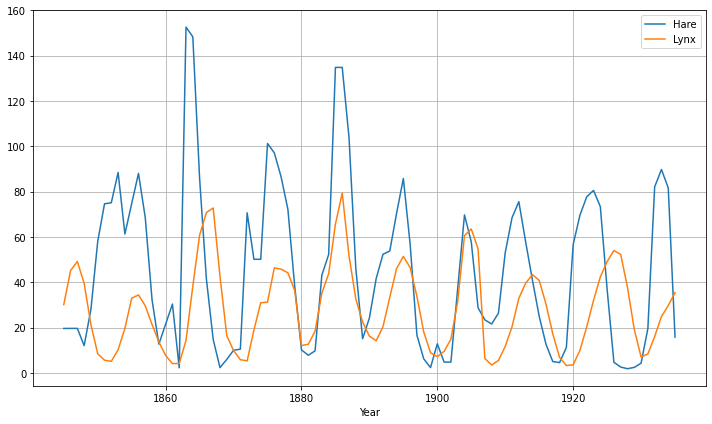

In [347]:
url = 'http://people.whitman.edu/~hundledr/courses/M250F03/LynxHare.txt'
df = pd.read_csv(url, delim_whitespace=True, header=None, index_col=0)
df.index.name = 'Year'
df.columns = ['Hare', 'Lynx']
df.plot(figsize=(10,6), grid=True)

In [348]:
year = df.index.to_numpy()
hare = df['Hare'].to_numpy()
lynx = df['Lynx'].to_numpy()
x_real = np.linspace(0, len(hare)-1, len(hare))

In [349]:
# hare = np.array([30, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22, 25.4, 27.1, 40.3, 57, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7])
# lynx = np.array([4, 6.1, 9.8, 35.2, 59.4, 41.7, 19, 13, 8.3, 9.1, 7.4, 8, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6])
# year = np.linspace(1900, 1920, 21)

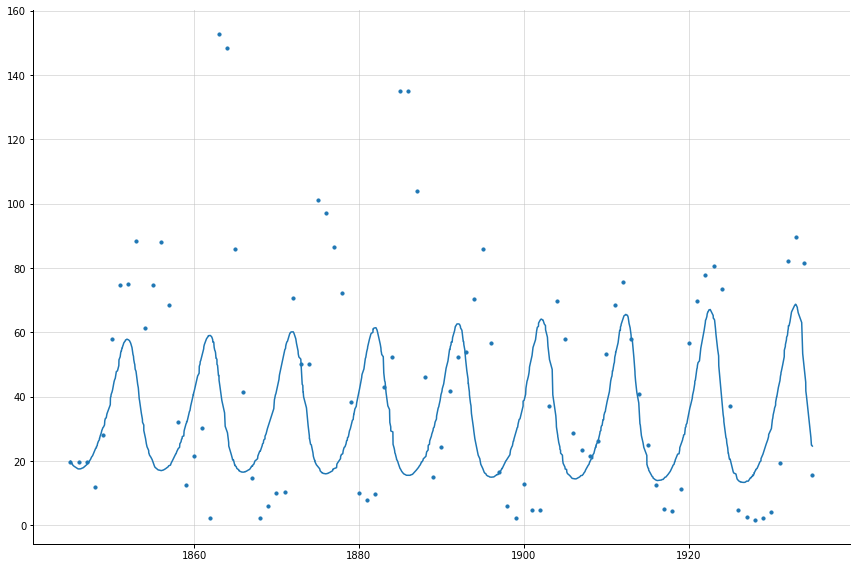

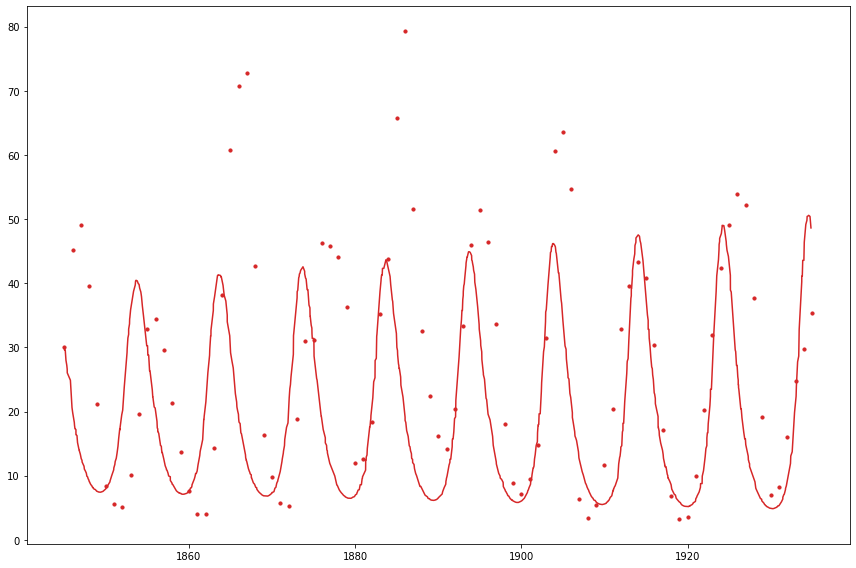

In [350]:
marker_size = 10

gen = PredPreyGenerator(
    torch.float32,
    seed=0,
    num_target=nps.UniformDiscrete(1000, 1000),
#     dist_x=nps.UniformContinuous(1900, year[-1])
    dist_x=nps.UniformContinuous(year[0], year[-1])

)
batch = gen.generate_batch()


plt.figure(figsize=(12, 8))
# Plot the preys (output 0).
xt = nps.batch_xt(batch, 0)[i, 0]
yt = nps.batch_yt(batch, 0)[i]
inds = B.argsort(xt)  # Sort before plotting to prevent a mess.
plt.plot(xt[inds], yt[inds], color='tab:blue')

# Plot the actuals
plt.scatter(year, hare, color='tab:blue', s=marker_size)
tweak()

plt.show()


plt.figure(figsize=(12, 8))
#  Plot the predators (output 1).
xt = nps.batch_xt(batch, 1)[i, 0]
yt = nps.batch_yt(batch, 1)[i]
inds = B.argsort(xt)
plt.plot(xt[inds], yt[inds], color='tab:red')
plt.scatter(year, lynx, color='tab:red', s=marker_size)
